In [2]:
import scipy.integrate as spi
from scipy.integrate import odeint
from array import *
from scipy.optimize import curve_fit
from statistics import mean
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#from ipynb.fs.full.HSV_Dyn_Functions import GetIndParams
#from ipynb.fs.full.HSV_Dyn_Functions import Vir_Dyn
#from ipynb.fs.full.HSV_Dyn_Functions import Vir_Dyn_IS
#from ipynb.fs.full.HSV_Dyn_Functions import Vir_Dyn_DDD
#from ipynb.fs.full.HSV_Dyn_Functions import RunSimulation
#from ipynb.fs.full.HSV_Dyn_Functions import RunSimulation_DD
#from ipynb.fs.full.HSV_Dyn_Functions import Plotting
%matplotlib inline

In [30]:
Indparameters_file_DDperI_betasup0_nk_15_burst = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-FredHutchinsonCancerResearchCenter/HSV cell culture kinetics/Projects/Vero/AveqPCR_DDDiff_perI_nk=15_delta_est_InitfrmData_burst_betaSup0/Assessment/AveqPCR_DDDiff_perI_nk=15_delta_est_InitfrmData_burst_betaSup0_004/Results/IndividualParameters/estimatedIndividualParameters.txt'

data_file = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-FredHutchinsonCancerResearchCenter/HSV cell culture kinetics/Data/Marius Data/TimeCourseAverPCR_Vero.csv'




Indparameters_DDperI15 = pd.read_csv(Indparameters_file_DDperI_nk_15)
Indparameters_DDperI15_betasup0 = pd.read_csv(Indparameters_file_DDperI_betasup0_nk_15)
Indparameters_DDperI15_betasup0_burst = pd.read_csv(Indparameters_file_DDperI_betasup0_nk_15_burst)

Indparameters_Lin15 = pd.read_csv(Indparameters_file_nk_15)
#print(Popparameters_11)
Data_Vero = pd.read_csv(data_file)

IDs = Data_Vero.ID.unique()
print(Indparameters_DDperI15_betasup0_burst)

     id  log10betaCell_SAEM  piCell_SAEM    D_SAEM    f_SAEM  kappa_SAEM  \
0  High            -7.19841      5251.98  0.047104  163.6190    1.374780   
1   Low            -7.19767      5244.15  0.046777   70.4619    0.824121   

   gamma_SAEM  deltaI_SAEM  log10K_SAEM  log10betaCell_mean  ...  deltaI_mode  \
0        0.04      0.28317      6.37370            -7.19722  ...     0.284008   
1        0.04      0.07204      6.37652            -7.19642  ...     0.072513   

   log10K_mode  log10betaCell_sd  piCell_sd      D_sd     f_sd  kappa_sd  \
0      6.37347          0.025528    83.9074  0.002245  84.5388  0.018430   
1      6.37560          0.025324    81.1661  0.002137  39.5676  0.009228   

   gamma_sd  deltaI_sd  log10K_sd  
0         0   0.026304   0.022753  
1         0   0.004778   0.022871  

[2 rows x 33 columns]


In [6]:
def GetIndParams(Indparameters, ID, style = 'mode'):
    ''' 
    input:
        - data frame with parameter values as columns, individuals as rows
        - ID identifying individual of interest
        - style = 'mode' or 'mean' or 'SAEM' depending on which parameter values are preferred
    return:
        - dictionary with parameter names as key and parameter values as values
    '''
    i = ID
    cols = list(Indparameters)
    pid_params = Indparameters[Indparameters.id == i]
  #  print(pid_params)
    values = []
    keys = []
    for c in cols:
        if style in c:
            k = c.split('_')[0]
            keys.append(k)
            v = pid_params[c].values[0]
            values.append(v)
        for i,(v,k) in enumerate(zip(values, keys)):
            if 'log10' in k:
                values[i] = 10**v
                keys[i] = k.split('0')[1]
    if 'alpha' in keys:
        i = keys.index('alpha')
        j = keys.index('kPL')
        values[j] = values[j]*dose**values[i]

    params = dict(zip(keys, values))
    return params

In [8]:
def RunSimulation(Vir_Dyn, Data, Indparameters, param_order, id, C_Tot, nk, N, Vcell0, Vsup0):
    Params_dict = GetIndParams(Indparameters, id, style = 'mode')
    params = []
    for k in param_order:
        params.append(Params_dict[k])
    params.append(nk)
    print(params)
    MOI = Data[Data.ID == id].MOI.unique()[0]
    Init = C_Tot*np.exp(-MOI), C_Tot*(1-np.exp(-MOI))
    for i in range(1,nk):
        Init = np.append(Init, 0)
    Init = np.append(Init, [0, Vcell0, Vsup0])
    Init = np.append(Init, 0)
    #print(Init)
    t = np.linspace(0, max(Data.time), N)
    y = spi.odeint(Vir_Dyn, Init, t, args = tuple(params))  
    return y.T

In [10]:
def RunSimulation_DDperI(Vir_Dyn, Data, Indparameters, param_order, id, C_Tot, nk, N, Vcell0, Vsup0):
    Params_dict = GetIndParams(Indparameters, id, style = 'mode')
    params = []
    for k in param_order:
        params.append(Params_dict[k])
    params.append(nk)
    print(params)
    MOI = Data[Data.ID == id].MOI.unique()[0]
    Init = C_Tot*np.exp(-MOI), C_Tot*(1-np.exp(-MOI))
    for i in range(1,nk):
        Init = np.append(Init, 0)
    Init = np.append(Init, [0.0, Vcell0, Vsup0])
    Init = np.append(Init, 0)
    #print(Init)
    t = np.linspace(0, max(Data.time), N)
    y = spi.odeint(Vir_Dyn, Init, t, args = tuple(params))  
    return y.T

In [12]:
def Vir_Dyn(y,t, betaSup, betaCell, piCell, D, k, deltaI, gamma, nk):
    dY = np.zeros(nk+5);
    E = np.zeros(nk)
    S = y[0]
    for i in range(1, nk+1):
        E[i-1] = y[i]
    I = y[nk+1]
    V_Cell = y[nk+2]
    V_Sup = y[nk+3]
    Dead = y[nk+4]
    dY[0] = -betaSup*V_Sup*S-betaCell*V_Cell*S
    dY[1] = betaSup*V_Sup*S+betaCell*V_Cell*S - k*E[0]
    for i in range(2, nk+1):
        dY[i] = k*(E[i-2]-E[i-1])
    dY[nk+1] = k*E[nk-1]-deltaI*I
    dY[nk+2] = piCell*I - D*V_Cell
    dY[nk+3] = D*V_Cell - gamma*V_Sup
    dY[nk+4] = deltaI*I
    
    
    return dY

In [20]:
def Vir_Dyn_DDD_perI_betasup0_withBurst(y,t, betaCell, piCell, D, k, deltaI, gamma, K, f, nk):
    dY = np.zeros(nk+5);
    E = np.zeros(nk)
    S = y[0]
    for i in range(1, nk+1):
        E[i-1] = y[i]
    I = y[nk+1]
    V_Cell = y[nk+2]
    V_Sup = y[nk+3]
    Dead = y[nk+4]
    dY[0] = -betaCell*V_Cell*S
    dY[1] = betaCell*V_Cell*S - k*E[0]
    for i in range(2, nk+1):
        dY[i] = k*(E[i-2]-E[i-1])
    dY[nk+1] = k*E[nk-1]-deltaI*I
    dY[nk+2] = piCell*I - (D*(V_Cell)/(V_Cell+K*I))*V_Cell-f*deltaI*I
    dY[nk+3] = (D*(V_Cell)/(V_Cell+K*I))*V_Cell + f*deltaI*I- gamma*V_Sup
    dY[nk+4] = deltaI*I
    
    
    return dY

In [22]:
param_order = ['betaCell', 'piCell', 'D', 'kappa', 'deltaI', 'gamma', 'K', 'f']
C_Tot = 300000
nk = 15
N = 10000 #timesteps
#i = 1
E_DDperI15_betasup0_burst = np.zeros((len(IDs),nk, N))
for id, idi in zip(IDs, range(0,len(IDs))):
    
    Vcell0 = float(Data_Vero[(Data_Vero.ID == id) & 
                                 (Data_Vero.time == 1) & 
                                 (Data_Vero.ObsID == 'Cell')].Aver_qPCR)

    Vsup0 = float(Data_Vero[(Data_Vero.ID == id) & 
                                 (Data_Vero.time == 1) & 
                                 (Data_Vero.ObsID == 'Sup')].Aver_qPCR)
    y = RunSimulation(Vir_Dyn_DDD_perI_betasup0_withBurst, Data_Vero, Indparameters_DDperI15_betasup0_burst, param_order, id, C_Tot, nk, N, 
                             Vcell0, Vsup0)

    if id == IDs[0]:
        S_DDperI15_betasup0_burst = y[0,:]
        for i in range(1, nk+1):
            E_DDperI15_betasup0_burst[idi,i-1,:] = y[i,:]
        I_DDperI15_betasup0_burst = y[nk+1,:]
        V_Cell_DDperI15_betasup0_burst = y[nk+2,:]
        V_Sup_DDperI15_betasup0_burst = y[nk+3,:]
        Dead_DDperI15_betasup0_burst = y[nk+4, :]
        
    else:
        S_DDperI15_betasup0_burst = np.vstack((S_DDperI15_betasup0_burst,y[0,:]))
        for i in range(1, nk+1):
            E_DDperI15_betasup0_burst[idi,i-1,:] = y[i,:]
        I_DDperI15_betasup0_burst = np.vstack((I_DDperI15_betasup0_burst,y[nk+1,:]))
        V_Cell_DDperI15_betasup0_burst = np.vstack((V_Cell_DDperI15_betasup0_burst,y[nk+2,:]))
        V_Sup_DDperI15_betasup0_burst = np.vstack((V_Sup_DDperI15_betasup0_burst,y[nk+3,:]))
        Dead_DDperI15_betasup0_burst = np.vstack((Dead_DDperI15_betasup0_burst, y[nk+4, :]))

[6.36033513737066e-08, 5250.96, 0.0466369, 1.37488, 0.284008, 0.04, 2363034.1608990394, 155.924, 15]
[6.361506862317098e-08, 5252.02, 0.0465326, 0.823806, 0.0725127, 0.04, 2374652.143651677, 65.0818, 15]


/var/folders/z2/v4k5h92d3x34xw1wf5f8b_nh0000gp/T/ipykernel_15863/1008040394.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  Vcell0 = float(Data_Vero[(Data_Vero.ID == id) &
/var/folders/z2/v4k5h92d3x34xw1wf5f8b_nh0000gp/T/ipykernel_15863/1008040394.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  Vsup0 = float(Data_Vero[(Data_Vero.ID == id) &


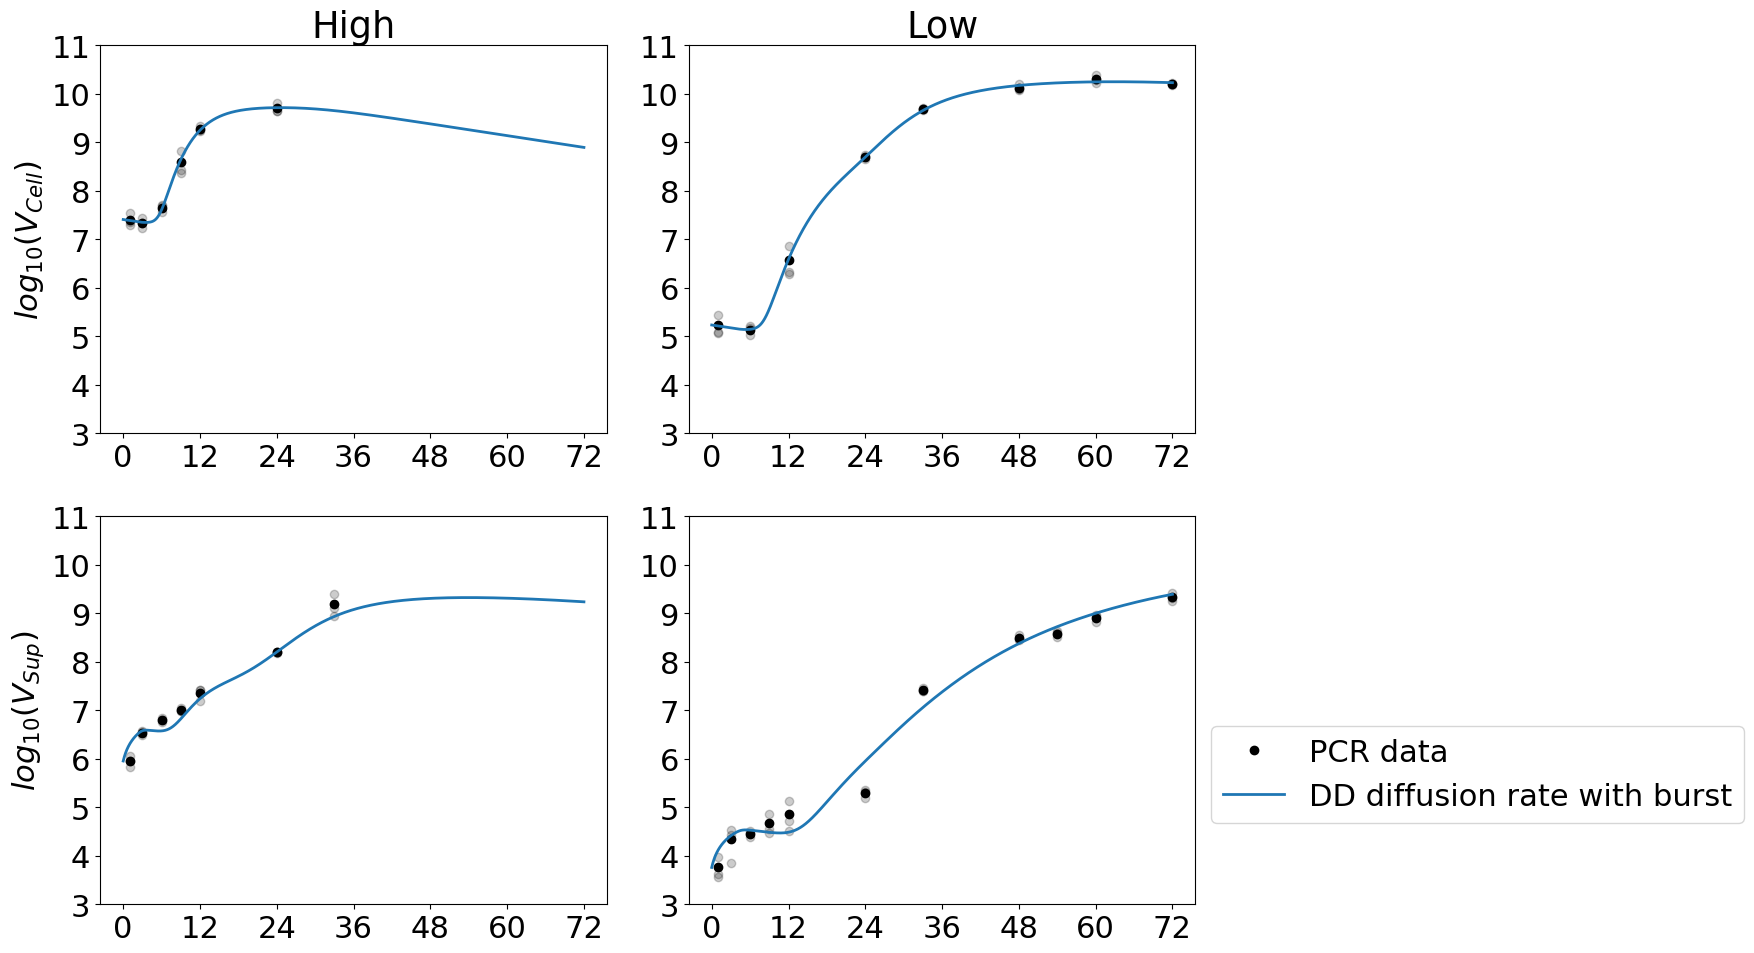

In [28]:
fig = plt.figure(figsize = (18,10))
plt.rcParams.update({'font.size': 22})
for id, idi in zip(IDs, range(0,len(IDs))):
    t_Celldata = Data_Vero[(Data_Vero.ID == id) & (Data_Vero.ObsID == 'Cell')].time
    temp = Data_Vero[(Data_Vero.ID == id) & (Data_Vero.ObsID == 'Cell')].log10_AvePCR
    y_Cell_1_PCR = Data_Vero[(Data_Vero.ID == id) & (Data_Vero.ObsID == 'Cell')].qPCR_1
    y_Cell_2_PCR = Data_Vero[(Data_Vero.ID == id) & (Data_Vero.ObsID == 'Cell')].qPCR_2
    y_Cell_3_PCR = Data_Vero[(Data_Vero.ID == id) & (Data_Vero.ObsID == 'Cell')].qPCR_3
    y_Celldata = [float(y) for y in temp]
    #print(temp)
    t_Supdata = Data_Vero[(Data_Vero.ID == id) & (Data_Vero.ObsID == 'Sup')].time
    temp = Data_Vero[(Data_Vero.ID == id) & (Data_Vero.ObsID == 'Sup')].log10_AvePCR
    y_Sup_1_PCR = Data_Vero[(Data_Vero.ID == id) & (Data_Vero.ObsID == 'Sup')].qPCR_1
    y_Sup_2_PCR = Data_Vero[(Data_Vero.ID == id) & (Data_Vero.ObsID == 'Sup')].qPCR_2
    y_Sup_3_PCR = Data_Vero[(Data_Vero.ID == id) & (Data_Vero.ObsID == 'Sup')].qPCR_3
    y_Supdata = [float(y) for y in temp]    

    t = np.linspace(0, max(Data_Vero.time), N)
    plt.subplot(2,2,idi+1)
    plt.plot(t_Celldata.values, np.log10(y_Cell_1_PCR),'o', alpha = 0.2,  color = 'black')
    plt.plot(t_Celldata.values, np.log10(y_Cell_2_PCR),'o', alpha = 0.2,  color = 'black')
    plt.plot(t_Celldata.values, np.log10(y_Cell_3_PCR),'o', alpha = 0.2,  color = 'black')
    plt.plot(t_Celldata.values, y_Celldata,'o', color = 'black')

 
    plt.plot(t,np.log10(V_Cell_DDperI15_betasup0_burst[idi,:]), linewidth = 2)

    plt.title(id)
    if idi ==0:
        plt.ylabel('$log_{10}(V_{Cell})$')
    plt.ylim([3, 11])
    plt.xticks(np.linspace(0,72,7))
    plt.yticks(range(3,12))
    plt.subplot(2,2,idi+3)
    plt.plot(t_Supdata.values, np.log10(y_Sup_1_PCR),'o', alpha = 0.2,  color = 'black')
    plt.plot(t_Supdata.values, np.log10(y_Sup_2_PCR),'o', alpha = 0.2,  color = 'black')
    plt.plot(t_Supdata.values, np.log10(y_Sup_3_PCR),'o', alpha = 0.2,  color = 'black')
    plt.plot(t_Supdata.values, y_Supdata,'o', color = 'black', label = 'PCR data')

    plt.plot(t,np.log10(V_Sup_DDperI15_betasup0_burst[idi,:]), linewidth = 2, label = 'DD diffusion rate with burst')

    if idi ==0:
        plt.ylabel('$log_{10}(V_{Sup})$')
        
    if idi ==1:
        plt.legend(bbox_to_anchor=(1, 0.5))
    plt.ylim([3, 11])
    plt.xticks(np.linspace(0,72,7))
    plt.yticks(range(3,12))
plt.tight_layout()
plt.show()
#plt.savefig('Figures/FittoAve_Vero_delta_est_3VirComp_LingapDiff_DDeDiffperIplusE_Vi_Ve_fromData.svg')
#plt.savefig('Figures/FittoAve_Vero_delta_est_3VirComp_LinGapDiff_DDeDiffperIplusE_Vi_Ve_fromData.png')